# Import Libraries and Define Test Function


This cell imports required utility functions, initializes the Rastrigin function as the test optimization function, and defines an initial set of test points in X_data. It also evaluates the function at these points and visualizes the function's 3D surface.

(<Figure size 1850x1050 with 1 Axes>, <Axes3D: >)

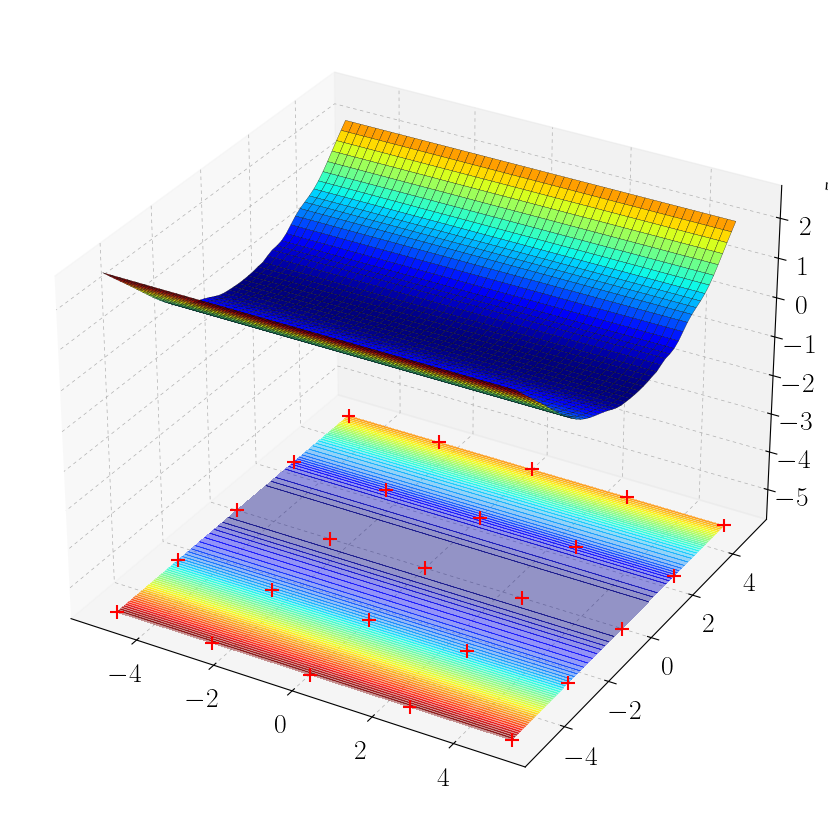

In [11]:
import utils
import numpy as np
import os
import json
import ioh

utils.good_plt_config()
os.makedirs("outputs", exist_ok=True)

data = []
with open("/home/neocortex/repos/LLaMEA-ELA/LLaMEA/exp-09-25_072937-LLaMEA-gpt-5-nano-ELA-Basins_Separable-sharing/log.jsonl", "r") as f:
    for line in f:
        if line.strip():  # skip empty lines
            data.append(json.loads(line))

row = data[1]
ns = {}
exec(row["code"], ns)                      # defines class with same name as row["name"]
F   = ioh.get_problem(2,1,2) #getattr(ns[row["name"]](dim=2), "f")      # instantiate & grab its .f method

n = 5
x1 = np.linspace(-5, 5, n)
x2 = np.linspace(-5, 5, n)
X1, X2 = np.meshgrid(x1, x2)
X_data = np.column_stack([X1.ravel(), X2.ravel()])

y_data = np.array([F(x) for x in X_data])
utils.plot_3D_surface((-5, 5), (-5, 5), F, X_data)

# Compute and Visualize Attraction Basins


This cell utilizes the `analyze_basins` module to classify the test points into attraction basins and visualize the basins.

Number of basins: 1
Basin 5980: size=25, f(x)=-209.8800


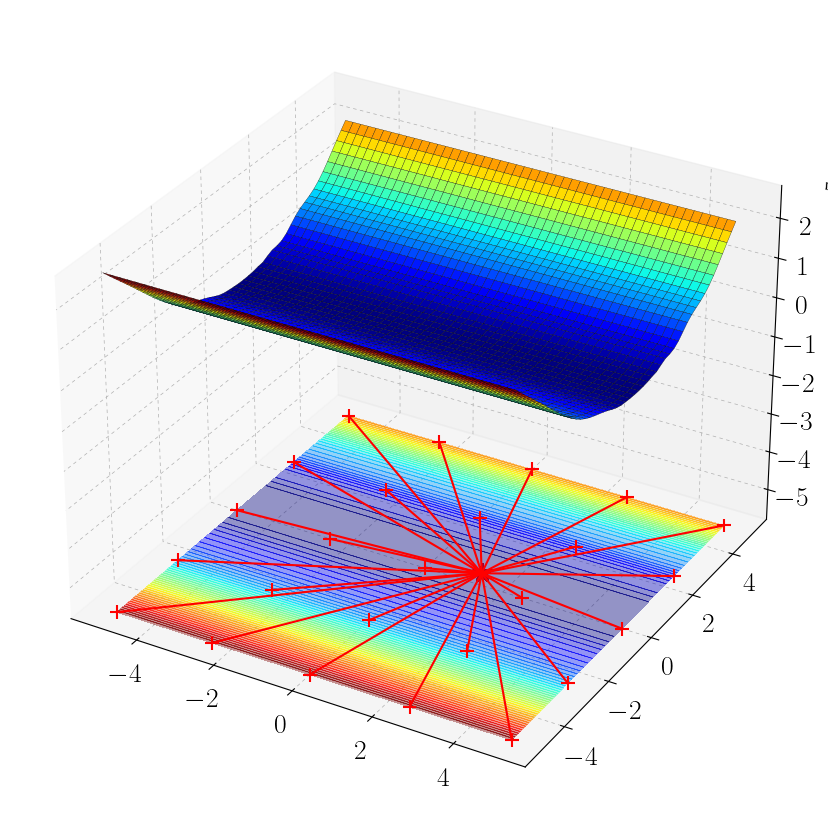

In [12]:
import analyze_basins

bloc = analyze_basins.BasinsLoc(MIN_DIST=0.002)
nr_of_optima = bloc.alg_closest_points(F, X=X_data, y=y_data)

n_init = len(X_data)

def find_root(i, to):
    while to[i] != i:
        to[i] = to[to[i]]
        i = to[i]
    return i

def collapse_to(to):
    cache = {}
    for i in range(len(to)):
        to[i] = find_root(i, to)
    return to

# After running alg_closest_points
to = np.array(bloc.to).copy()
roots = collapse_to(to)
roots_init = roots[:n_init]

unique_basins, counts = np.unique(roots_init, return_counts=True)

basin_info = []

print(f"Number of basins: {len(unique_basins)}")
for basin_id, size in zip(unique_basins, counts):
    print(f"Basin {basin_id}: size={size}, f(x)={F(bloc.X[basin_id]):.4f}")
    basin_info.append((size, F(bloc.X[basin_id])))

fig, ax = bloc.plot_attraction_basins(F, X=X_data)

# Test on Sphere Function


This cell switches to a different test function, the Sphere function, and repeats the process of initializing points, evaluating the function, and visualizing the function surface.


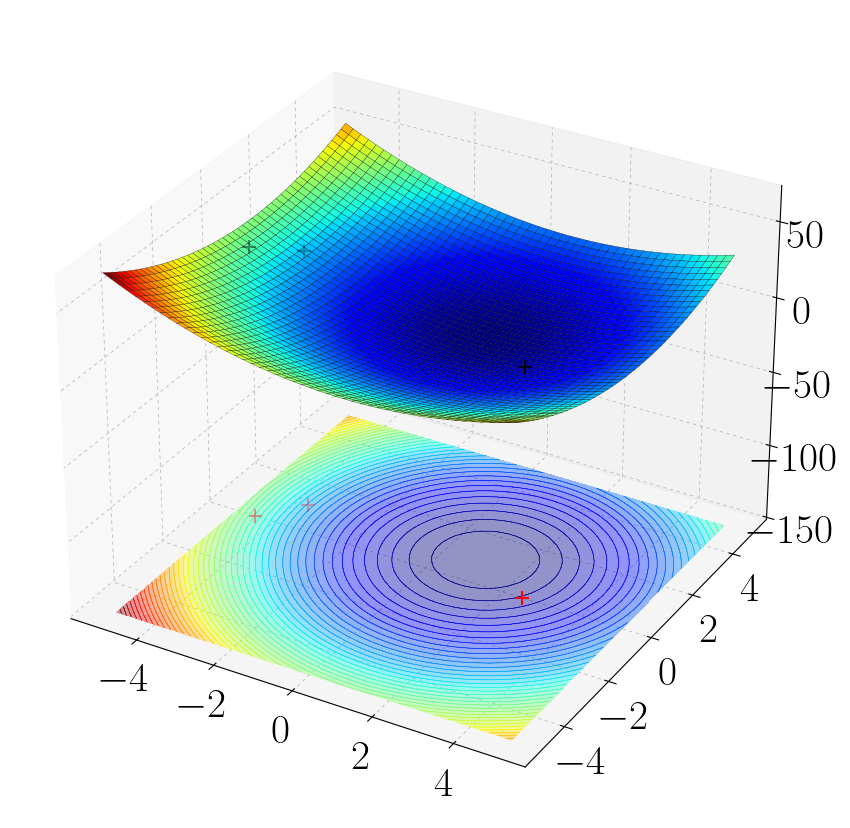

In [86]:
import utils
import numpy as np
from importlib import reload
reload(utils)

utils.good_plt_config()
F = utils.sphere
X_data = np.array(
    [
        [-4.5, 0],
        [-3.7, 1],
        [2.5, 0],
    ]
)


y_data = np.array([F(x) for x in X_data])
ax, fig = utils.plot_3D_surface((-5, 5), (-5, 5), F, X_data)

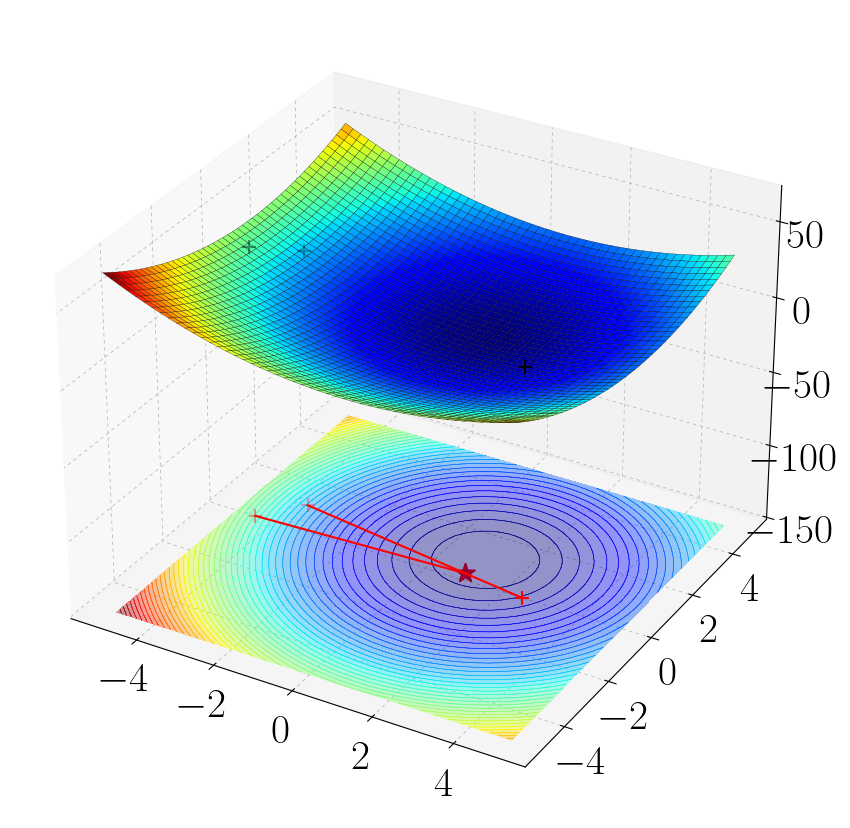

In [87]:
bloc = analyze_basins.BasinsLoc()
bloc.alg_closest_points(F, X=X_data, y=y_data)
fig, ax = bloc.plot_attraction_basins(F, X=X_data)

# Pathfinding in Attraction Basins

This cell implements a pathfinding function to determine whether two points belong to the same attraction basin by checking if an improving path exists between them.

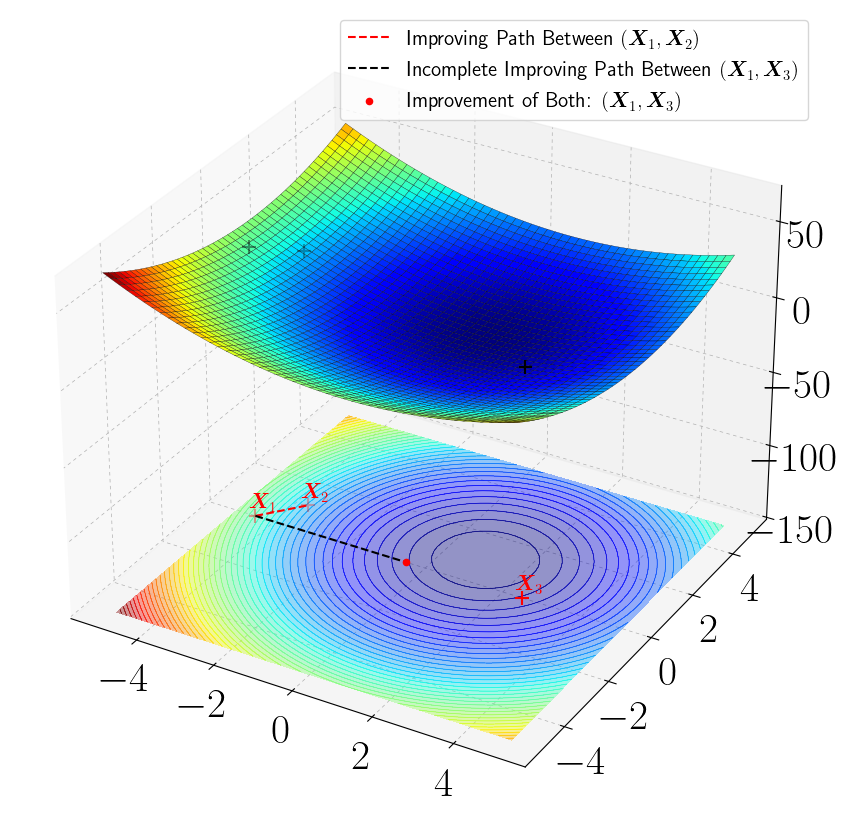

In [89]:
import analyze_basins
import json

fig, ax = utils.plot_3D_surface((-5, 5), (-5, 5), F, X_data)
zax_min, _ = ax.get_zlim()


def check_dominance(p1, p2, F, is_verbose=False):
    bloc = analyze_basins.BasinsLoc()
    ret = bloc.find_path(p1, F(p1), p2, F(p2), F, bloc.MIN_DIST)
    ret.x = ret.x.tolist()
    ret.path = np.array(ret.path).tolist()
    p1_str = ",".join([f"{x:.5f}" for x in p1])
    p2_str = ",".join([f"{x:.5f}" for x in p2])
    if is_verbose:
        print(f"Result of path finding between points [{p1_str}] and [{p2_str}]")
        print(json.dumps(ret.__dict__, indent=4))
    return ret


ret = check_dominance(X_data[0], X_data[1], F)
p = np.array(ret.path)
ax.plot(
    p[:, 0],
    p[:, 1],
    zax_min,
    c="red",
    linestyle="--",
    zorder=4,
    label=r"Improving Path Between $\br{\bm{X}_1, \bm{X}_2}$",
)

ret = check_dominance(X_data[0], X_data[2], F)
p = np.array(ret.path)
ax.plot(
    p[:, 0],
    p[:, 1],
    zax_min,
    c="black",
    linestyle="--",
    zorder=4,
    label=r"Incomplete Improving Path Between $\br{\bm{X}_1, \bm{X}_3}$",
)

ax.text(
    X_data[0, 0] - 0.3,
    X_data[0, 1] + 0.2,
    zax_min,
    zorder=4,
    s=r"$\bm{X}_1$",
    fontsize=15,
    c="red",
)
ax.text(
    X_data[1, 0] - 0.3,
    X_data[1, 1] + 0.2,
    zax_min,
    zorder=4,
    s=r"$\bm{X}_2$",
    fontsize=15,
    c="red",
)
ax.text(
    X_data[2, 0] - 0.3,
    X_data[2, 1] + 0.2,
    zax_min,
    zorder=4,
    s=r"$\bm{X}_3$",
    fontsize=15,
    c="red",
)
ax.scatter(
    p[-1, 0],
    p[-1, 1],
    zax_min,
    "ro",
    c="red",
    zorder=4,
    label=r"Improvement of Both: $(\bm{X}_1, \bm{X}_3)$",
)
ax.legend(fontsize=15)

# Create and configure Gallagher function

In [1]:
import utils
from importlib import reload

reload(utils)

utils.good_plt_config()

mygallagher = utils.GallagherFunction(
    num_peaks=15,
    dim=2,
    min_peak_distance=2,
    min_cond_number=1,
    mean_cond_number=10,
    max_cond_number=100,
    min_dist=5,
    max_dist=20,
    seed=44,
)

print(
    "Cond numbers, Max/Min eigenvalues:",
    *[
        f"{v:.5f}, {e2:.5f}/{e1:.5f}"
        for v, e1, e2 in zip(
            mygallagher.cond_numbers,
            mygallagher.min_eigvalues,
            mygallagher.max_eigvalues,
        )
    ],
    sep="\n\t",
)

Cond numbers, Max/Min eigenvalues:
	50.55358, 0.74460/0.01473
	4.02052, 0.51482/0.12805
	10.68939, 0.92219/0.08627
	5.67640, 1.35670/0.23901
	11.73951, 0.57230/0.04875
	12.57416, 0.78794/0.06266
	7.07686, 0.53584/0.07572
	1.17389, 0.70969/0.60456
	2.67947, 0.51888/0.19365
	8.91708, 1.10871/0.12434
	1.21968, 1.19410/0.97903
	23.37203, 1.22738/0.05251
	19.33200, 0.50760/0.02626
	3.17634, 0.63009/0.19837
	31.46693, 0.61810/0.01964


(<Figure size 1850x1050 with 2 Axes>,
 <Axes3D: xlabel='$x_1$', ylabel='$x_2$', zlabel='$\\text{\\textbf{\\textcolor{red}{(inversed)}}}$ $f\\!\\br{\\bm{x}}$'>)

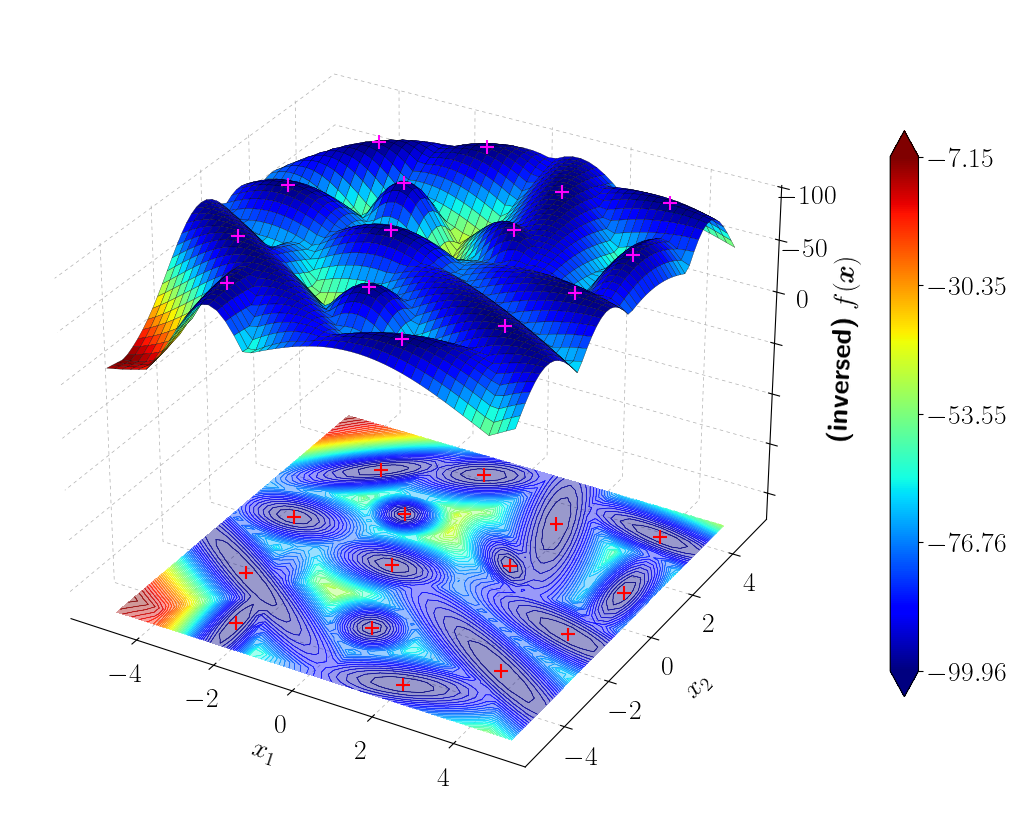

In [2]:
reload(utils)
utils.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    mygallagher,
    mygallagher.peaks,
    discretization=50,
    is_white_facecolor=True,
    zfactor=1.2,
    is_colorbar=True,
    is_inverse=True,
    is_remove_extra_zlables=True,
    is_axis_names=True,
    zlabelpad=10,
    is_scatter_objective_space=True,
    is_connect_search_obj=False
)